# We want to create an algorithm that will select the best strategy at any given datapoint based on the profitablility over the last 1 hour.
## To do this we'll need to create many dataframes and compare them.
##
Do all of our imports up top

In [2]:
import numpy as np
import os
import pickle
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import pandas.io.data as web
%matplotlib inline

In [3]:
def get_dataframe():
    mydata = None
    try:
        mydata = pickle.load(open('modelling/stats_pickle5', 'rb'))
    except:
        mydata = pickle.load(open('../resources/stats_pickle5', 'rb'))
    df = pd.DataFrame(mydata, columns=["Time", "Value"])
    df = df.set_index('Time')
    return df

In [4]:
class Name():
    def __init__(self, means, sd):
        self.mean1 = str(means[0])+"hr"
        self.mean1_val = means[0]
        self.mean2 = str(means[1])+"hr"
        self.mean2_val = means[1]
        self.name = "{}-{}-{}".format(self.mean1,self.mean2,sd)
        self.sd = sd
        self.strategy = "Strategy-{}-%.1f".format(self.name) % sd
        self.regime = "Regime-{}-%.1f".format(self.name) % sd
        self.cumsum = "Cumulative-{}-%.1f".format(self.name) % sd
    
    @classmethod
    def from_strategy_name(cls, strat):
        parts = strat.split('-')
        return cls([p.rstrip("hr") for p in parts[1:3]],float(parts[3]))

In [5]:
class StrategySelector():
    def __init__(self, dataframe, name, means, sds):
        self.dataframe = dataframe
        self.current_strategy=None
        self.means = means
        self.create_means()
        self.set_market()
        self.available_stategies = [Name(means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
        for name in regime_and_strategy_names:
            self.create_diff(name)
            self.create_regime(name)
            self.create_strategy(name)
    
    def strategies(self):
        return self.dataframe[[n.strategies for n in self.available_stategies]]
    def create_means(self):
        for mean in self.means:
            self.dataframe[str(mean)+"hr"] = np.round(pd.rolling_mean(df['Value'], window=mean*60), 2)

    def create_diff(self, name):
            self.dataframe[name.name] = self.dataframe[name.mean1] - self.dataframe[name.mean2]

    def create_regime(self, name):
        self.dataframe[name.regime] = np.where(self.dataframe[name.name] > name.sd, 1, 0)
        self.dataframe[name.regime] = np.where(self.dataframe[name.name] < -name.sd, -1, self.dataframe[name.regime])

    def set_market(self):
        self.dataframe['Market'] = np.log(self.dataframe['Value']/ self.dataframe['Value'].shift(1))
        self.dataframe['Market-cumulative'] = self.dataframe['Market'].cumsum().apply(np.exp)

    def create_strategy(self, name):
        self.dataframe[name.strategy] = self.dataframe[name.regime].shift(5) * self.dataframe['Market']
    
    def select_on_time_performance(hours=1):
        dataframe2= self.strategies.cumsum().apply(np.exp) - self.strategies.cumsum().apply(np.exp).shift(hours*60)
        
        #self.dataframe['best_{}_hours'.format(hours)] = self.dataframe[]
        last_24 = df[-2880:][[a.strategy for a in regime_and_strategy_names]].cumsum().apply(np.exp)[-1:].transpose().sort([df.index.tolist()[-1]],ascending=[0])

In [169]:
class Dataset():
    def __init__(self, loc):
        mydata = None
        try:
            mydata = pickle.load(open('modelling/{}'.format(loc), 'rb'))
        except:
            mydata = pickle.load(open('../resources/{}'.format(loc), 'rb'))
        self.dataset = pd.DataFrame(mydata, columns=["Time", "Value"]).drop_duplicates()
        self.dataset["Time"] = pd.to_datetime(self.dataset["Time"])
        self.dataset = self.dataset.set_index('Time')
        
        self.dataset['Market'] = np.log(self.dataset['Value']/ self.dataset['Value'].shift(1))
        
        
    
class Strategy():
    def __init__(self, dataset, means=None, sd=None, name=None):
        
        if name is None: 
            self.name = Name(means, sd)
            cols = list(dataset.columns.values)
            if self.name.mean1 not in cols:
                dataset[self.name.mean1] = np.round(pd.rolling_mean(dataset['Value'], window=self.name.mean1_val*60), 2)
            if self.name.mean2 not in cols:
                dataset[self.name.mean2] = np.round(pd.rolling_mean(dataset['Value'], window=self.name.mean2_val*60), 2)

            self.dataset = pd.DataFrame(dataset[['Market',self.name.mean1, self.name.mean2]])
            # Find our Diff
            self.dataset['Difference']= self.dataset[self.name.mean1] - self.dataset[self.name.mean2]
            # Set our Regime
            self.dataset['Regime'] = np.where(self.dataset['Difference'] > self.name.sd, 1, 0)
            self.dataset['Regime'] = np.where(self.dataset['Difference'] < -self.name.sd, -1, self.dataset['Regime'])
            self.dataset['Strategy'] = self.dataset['Regime'].shift(1) * self.dataset['Market']
            self.dataset['hourly_gain'] = self.dataset['Strategy'].cumsum().apply(np.exp) - self.dataset['Strategy'].shift(60).cumsum().apply(np.exp)
        else:
            self.dataset = pd.DataFrame(dataset[['Market','Regime']]).convert_objects(convert_numeric=True)
            self.dataset['Strategy'] = self.dataset['Regime'] * self.dataset['Market']
            
        


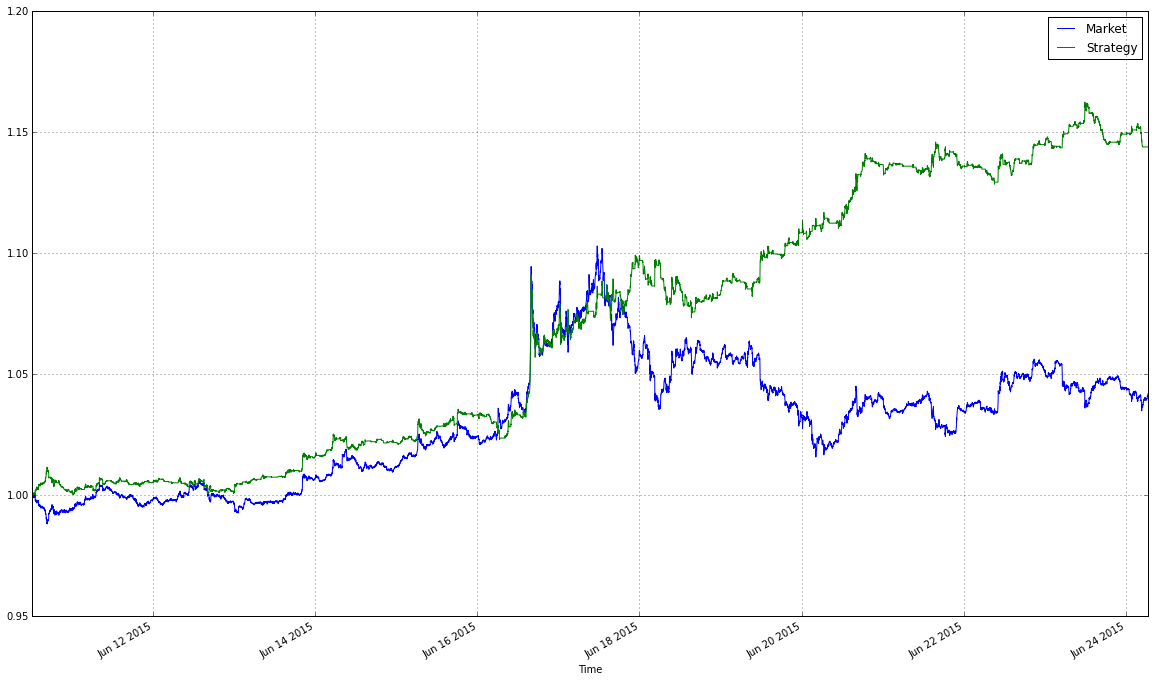

In [178]:
df = Dataset('stats_pickle5')
means = range(1,24)
SDs = np.arange(0.1,1,0.1)
strategies = [Strategy(df.dataset, means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]
items = {s.name.name:s.dataset for s in strategies}
pan = pd.Panel(items)

hourly_gains = pan.transpose(2,0,1)['hourly_gain'].transpose().dropna()

regimes = pan.transpose(2,0,1)['Regime'].transpose().dropna()

regimes['Market'] = df.dataset['Market']
regimes['winning_strategy_name'] = hourly_gains.idxmax(axis=1).dropna()
# winner = regimes['winning_strategy_name'].dropna()
regimes = regimes[regimes['winning_strategy_name'].notnull()]
column_list = regimes.columns.values.tolist()
column_dict = {value:index for index, value in enumerate(column_list)}
# groups = regimes.groupby('winning_strategy_name')
#regimes['winning_strategy_index'] = column_dict[regimes['winning_strategy_name']]
#regimes['winning_strategy_index'] 
# winner_index = column_list[winner].index
# winner_index
# regimes['winning_strategy_name']
regimes["winning_strategy_index"] =  0
# regimes.columns.tolist().index(name.name.name), -1)
winners = pd.DataFrame(regimes.ix[1440:])
#winners['winning_strategy_index'].value_counts()
winners['hourly_names'] = winners['winning_strategy_name'].asfreq(pd.DateOffset(minutes=15))
winners['hourly_names']=winners['hourly_names'].fillna(method='pad')
winners['Regime'] = 0
for group in column_list:
    winners["Regime"] = np.where(winners['hourly_names'] == group,winners[group],winners["Regime"])

s = Strategy(winners, name="Hourly Best")
s.dataset[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(20,12))


In [179]:
pickle.dump(s,open('../resources/awesome_results', 'wb'))

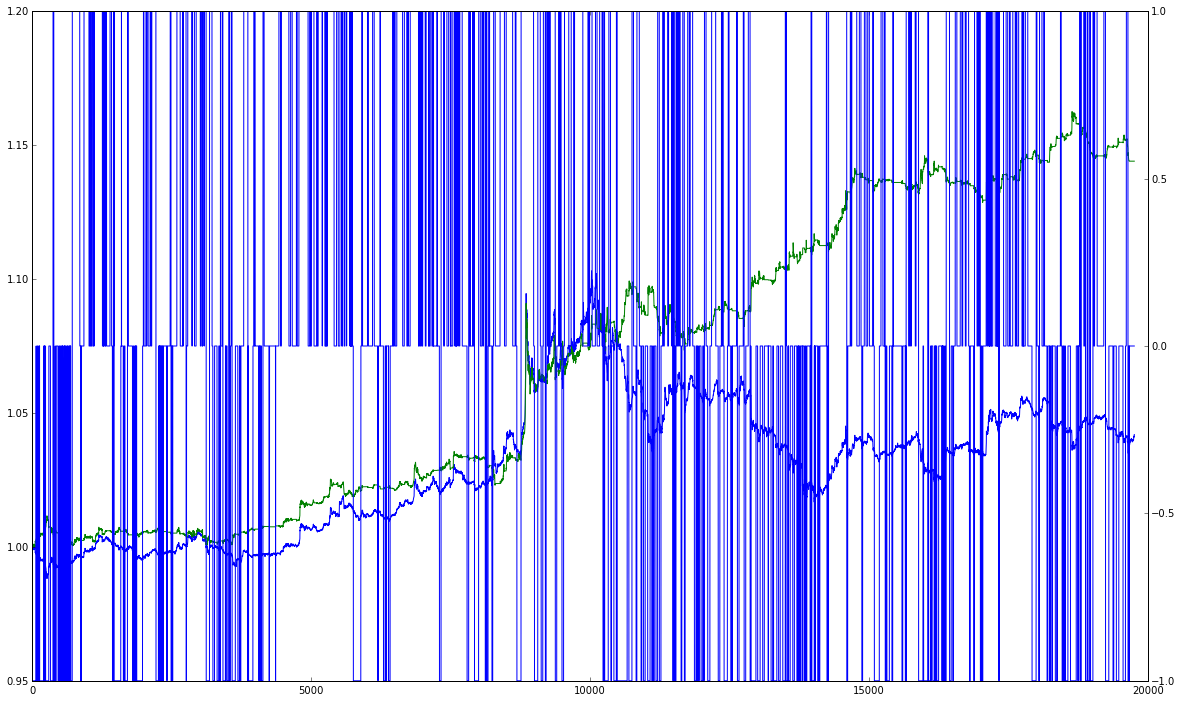

In [201]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
ax1.plot(s.dataset[['Market', 'Strategy']].cumsum().apply(np.exp))#.plot(grid=True, figsize=(20,12))
ax2 = ax1.twinx()
ax2.plot(s.dataset[['Regime']])
fig.set_size_inches(20,12)
plt.show()
#dir(fig)

In [205]:
df2 = Dataset('stats_pickle88')
means = range(1,12)
SDs = np.arange(0.1,0.6,0.1)
strategies = [Strategy(df2.dataset, means, sd) for means in list(itertools.combinations(means, 2)) for sd in SDs]

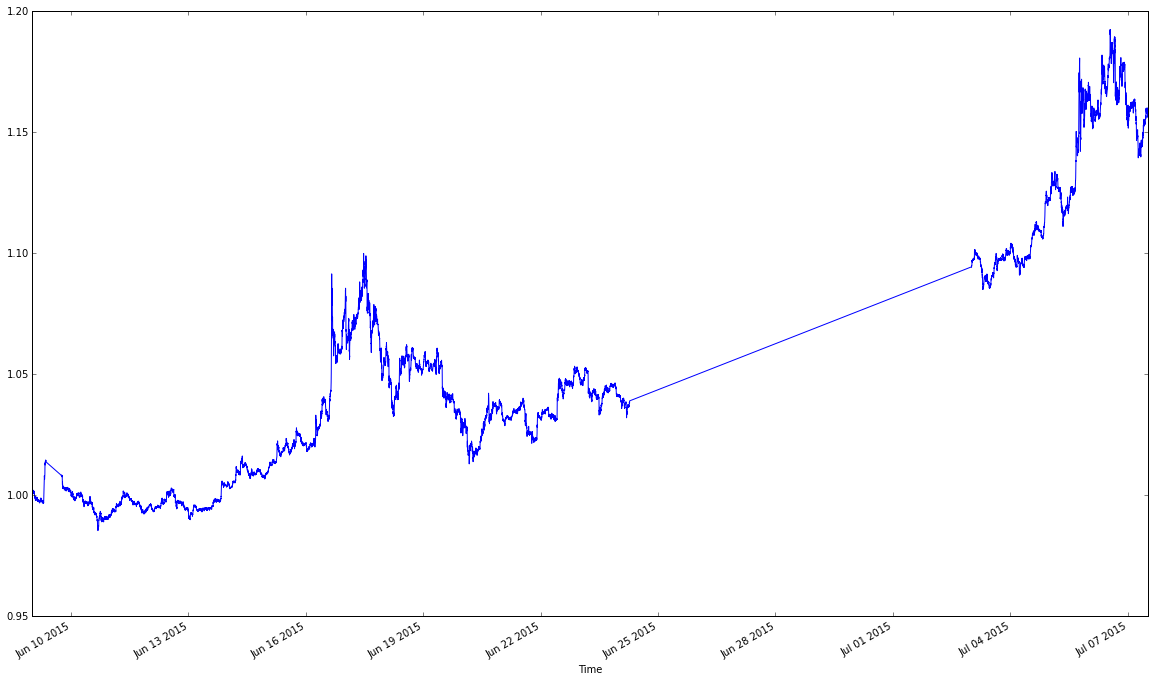

In [208]:
df2.dataset['Market'].cumsum().apply(np.exp).plot()